In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from collect_data import *
from tqdm import tqdm

In [2]:
for img, _ in train_loader:
    print(img.shape) 
    break 

torch.Size([64, 3, 150, 150])


In [3]:
class CNN(nn.Module):
    def __init__(self, num_classes=75):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten_size = self._get_flatten_size()
        
        self.fc1 = nn.Linear(in_features=self.flatten_size, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        
    def _get_flatten_size(self):
        x = torch.randn(1, 3, 150, 150)
        x = self.max_pool(F.relu(self.conv_layer1(x)))
        x = self.max_pool(F.relu(self.conv_layer2(x)))
        x = self.max_pool(F.relu(self.conv_layer3(x)))
        return x.view(1, -1).size(1)
        
    def forward(self, x):
        x = F.relu(self.conv_layer1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_layer2(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_layer3(x))
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model = CNN(num_classes=75).to(device)
print(model)

CNN(
  (conv_layer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=20736, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=75, bias=True)
)


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
def train(model, num_epochs, loss_fn=loss_fn, train_loader=train_loader, optimizer=optimizer, device=device):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        correct_train = 0
        total_train = 0
        
        for batch in tqdm(train_loader):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_train += labels.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()
            
        acc_train = 100 * correct_train / total_train
        train_acc.append(acc_train)
        avg_train_loss = total_loss / len(train_loader)
        train_loss.append(avg_train_loss)
        
        model.eval()
        loss_val = 0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader):
                images, labels = batch
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, labels)

                loss_val += loss.item()
                total_val += labels.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()
                
        acc_val = 100 * correct_val / total_val
        val_acc.append(acc_val)
        avg_val_loss = loss_val / len(val_loader)
        val_loss.append(avg_val_loss)
        
        print(f"Epoch ({epoch+1}/{num_epochs}) train accuracy: {acc_train}, val accuracy: {acc_val}, train loss: {avg_train_loss}, val loss: {avg_val_loss}")
        
    return train_loss, val_loss, train_acc, val_acc

In [8]:
def plot_training_curve(train_acc, val_acc, train_loss, val_loss):
    threshold = 95
    plt.figure(figsize=(10, 6))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold (95%)')
    
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.title("Training & Validation Metrics")
    plt.legend()
    plt.grid(True)
    plt.show()

100%|██████████| 21/21 [00:13<00:00,  1.50it/s]


Epoch (1/30) train accuracy: 9.213310251971533, val accuracy: 16.846153846153847, train loss: 3.758140700619395, val loss: 14.67464464051383


100%|██████████| 21/21 [00:14<00:00,  1.48it/s]


Epoch (2/30) train accuracy: 28.601654164262357, val accuracy: 35.61538461538461, train loss: 2.693328511424181, val loss: 10.51680656841823


100%|██████████| 21/21 [00:14<00:00,  1.49it/s]


Epoch (3/30) train accuracy: 41.12329294095018, val accuracy: 38.84615384615385, train loss: 2.145927219856076, val loss: 8.379334858485631


100%|██████████| 21/21 [00:14<00:00,  1.41it/s]


Epoch (4/30) train accuracy: 47.778418926716675, val accuracy: 46.76923076923077, train loss: 1.8433316030153415, val loss: 7.197771021298


100%|██████████| 21/21 [00:14<00:00,  1.42it/s]


Epoch (5/30) train accuracy: 54.568186189651854, val accuracy: 49.84615384615385, train loss: 1.5877345596871726, val loss: 6.199725423540388


100%|██████████| 21/21 [00:14<00:00,  1.48it/s]


Epoch (6/30) train accuracy: 57.95345258703597, val accuracy: 53.53846153846154, train loss: 1.4492936803073417, val loss: 5.659146751676287


100%|██████████| 21/21 [00:14<00:00,  1.49it/s]


Epoch (7/30) train accuracy: 61.0309674937488, val accuracy: 56.0, train loss: 1.3067738123056365, val loss: 5.102640600431533


100%|██████████| 21/21 [00:13<00:00,  1.50it/s]


Epoch (8/30) train accuracy: 63.93537218695903, val accuracy: 57.76923076923077, train loss: 1.2197578491234198, val loss: 4.7628639822914485


100%|██████████| 21/21 [00:14<00:00,  1.44it/s]


Epoch (9/30) train accuracy: 67.60915560684747, val accuracy: 57.84615384615385, train loss: 1.0997379240466327, val loss: 4.294214751039233


100%|██████████| 21/21 [00:14<00:00,  1.50it/s]


Epoch (10/30) train accuracy: 69.99422965954992, val accuracy: 59.07692307692308, train loss: 1.025584357540782, val loss: 4.0046627294449575


100%|██████████| 21/21 [00:14<00:00,  1.48it/s]


Epoch (11/30) train accuracy: 69.91729178688209, val accuracy: 60.38461538461539, train loss: 0.9798957007687267, val loss: 3.8262594030016945


100%|██████████| 21/21 [00:14<00:00,  1.49it/s]


Epoch (12/30) train accuracy: 73.57184073860358, val accuracy: 61.38461538461539, train loss: 0.8763650459487263, val loss: 3.421996846085503


100%|██████████| 21/21 [00:13<00:00,  1.51it/s]


Epoch (13/30) train accuracy: 75.30294287362955, val accuracy: 62.07692307692308, train loss: 0.8272257621695356, val loss: 3.2301196427572343


100%|██████████| 21/21 [00:14<00:00,  1.48it/s]


Epoch (14/30) train accuracy: 76.20696287747644, val accuracy: 62.92307692307692, train loss: 0.7780717956583675, val loss: 3.0381851068564822


100%|██████████| 21/21 [00:14<00:00,  1.49it/s]


Epoch (15/30) train accuracy: 78.39969224850933, val accuracy: 62.69230769230769, train loss: 0.7141076958760982, val loss: 2.7884205267542885


100%|██████████| 21/21 [00:14<00:00,  1.47it/s]


Epoch (16/30) train accuracy: 79.09213310251971, val accuracy: 62.61538461538461, train loss: 0.6644244063191298, val loss: 2.5944191103889827


100%|██████████| 21/21 [00:14<00:00,  1.50it/s]


Epoch (17/30) train accuracy: 80.93864204654741, val accuracy: 62.69230769230769, train loss: 0.6211732705918754, val loss: 2.4255337232635137


100%|██████████| 21/21 [00:14<00:00,  1.50it/s]


Epoch (18/30) train accuracy: 81.36180034622042, val accuracy: 62.23076923076923, train loss: 0.6018289382137904, val loss: 2.3499987111205147


100%|██████████| 21/21 [00:14<00:00,  1.49it/s]


Epoch (19/30) train accuracy: 82.3619926909021, val accuracy: 65.0, train loss: 0.5547669071976732, val loss: 2.166232685248057


100%|██████████| 21/21 [00:14<00:00,  1.49it/s]


Epoch (20/30) train accuracy: 82.93902673591076, val accuracy: 64.3076923076923, train loss: 0.5404260710972112, val loss: 2.1102351347605386


100%|██████████| 21/21 [00:14<00:00,  1.43it/s]


Epoch (21/30) train accuracy: 83.57376418542027, val accuracy: 63.46153846153846, train loss: 0.5190913679032791, val loss: 2.026928198479471


100%|██████████| 21/21 [00:14<00:00,  1.50it/s]


Epoch (22/30) train accuracy: 84.88170802077323, val accuracy: 63.61538461538461, train loss: 0.4867166137186492, val loss: 1.900512491663297


100%|██████████| 21/21 [00:14<00:00,  1.48it/s]


Epoch (23/30) train accuracy: 85.72802462011926, val accuracy: 64.53846153846153, train loss: 0.4499081313246634, val loss: 1.756784131839162


100%|██████████| 21/21 [00:14<00:00,  1.49it/s]


Epoch (24/30) train accuracy: 85.5356799384497, val accuracy: 62.84615384615385, train loss: 0.4436682300960145, val loss: 1.7324188032320567


100%|██████████| 21/21 [00:14<00:00,  1.49it/s]


Epoch (25/30) train accuracy: 87.18984420080785, val accuracy: 65.07692307692308, train loss: 0.40045584156745817, val loss: 1.5636847146919794


100%|██████████| 21/21 [00:14<00:00,  1.43it/s]


Epoch (26/30) train accuracy: 88.09386420465474, val accuracy: 64.3076923076923, train loss: 0.38382937450234483, val loss: 1.4987623194853466


100%|██████████| 21/21 [00:15<00:00,  1.40it/s]


Epoch (27/30) train accuracy: 88.6708982496634, val accuracy: 65.0, train loss: 0.35250823563191946, val loss: 1.3764607296103524


100%|██████████| 21/21 [00:14<00:00,  1.49it/s]


Epoch (28/30) train accuracy: 89.4018080400077, val accuracy: 64.61538461538461, train loss: 0.33562464703147005, val loss: 1.310534336027645


100%|██████████| 21/21 [00:14<00:00,  1.49it/s]


Epoch (29/30) train accuracy: 89.36333910367378, val accuracy: 63.07692307692308, train loss: 0.33511801481973835, val loss: 1.3085560578675497


100%|██████████| 21/21 [00:14<00:00,  1.49it/s]


Epoch (30/30) train accuracy: 89.63262165801116, val accuracy: 64.53846153846153, train loss: 0.3092326199317851, val loss: 1.2074797540193511


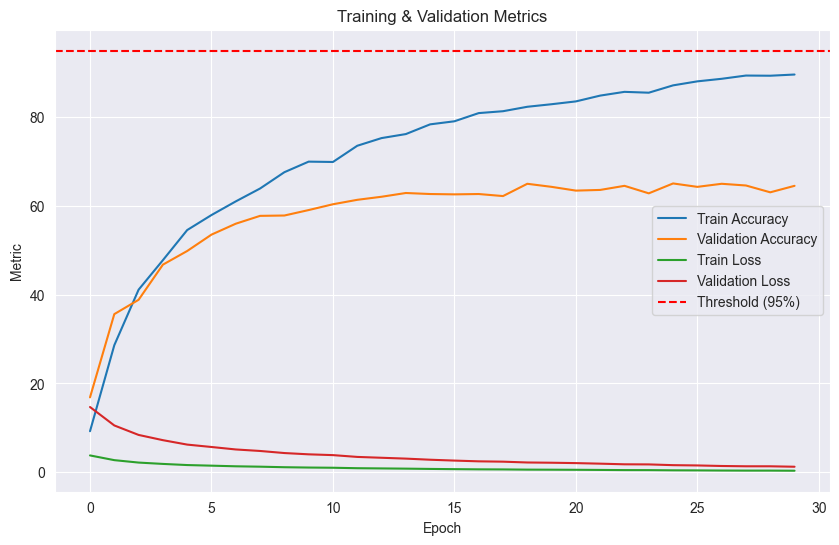

In [9]:
train_loss, val_loss, train_acc, val_acc = train(model, num_epochs=30)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

In [10]:
class CNN_v2(nn.Module):
    def __init__(self, num_classes=75):
        super(CNN_v2, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten_size = self._get_flatten_size()
        
        #out features 256 instead of 128
        self.fc1 = nn.Linear(in_features=self.flatten_size, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=num_classes)
        
    def _get_flatten_size(self):
        x = torch.randn(1, 3, 150, 150)
        x = self.max_pool(F.relu(self.conv_layer1(x)))
        x = self.max_pool(F.relu(self.conv_layer2(x)))
        x = self.max_pool(F.relu(self.conv_layer3(x)))
        return x.view(1, -1).size(1)
        
    def forward(self, x):
        x = F.relu(self.conv_layer1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_layer2(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_layer3(x))
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        
        return x

In [11]:
model_v2 = CNN_v2(75).to(device)
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=0.001)
print(model_v2)

CNN_v2(
  (conv_layer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv_layer3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18496, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=75, bias=True)
)


100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Epoch (1/30) train accuracy: 8.136180034622043, val accuracy: 14.384615384615385, train loss: 3.7392685820416705, val loss: 14.600953510829381


100%|██████████| 21/21 [00:18<00:00,  1.16it/s]


Epoch (2/30) train accuracy: 23.216003077514905, val accuracy: 26.076923076923077, train loss: 2.8812797970888093, val loss: 11.250711588632493


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Epoch (3/30) train accuracy: 36.5262550490479, val accuracy: 38.84615384615385, train loss: 2.3719973869440034, val loss: 9.262085034733726


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Epoch (4/30) train accuracy: 45.31640700134641, val accuracy: 44.92307692307692, train loss: 1.9641731148812829, val loss: 7.669628353345962


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Epoch (5/30) train accuracy: 52.010001923446815, val accuracy: 46.0, train loss: 1.70354231392465, val loss: 6.651927130562918


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Epoch (6/30) train accuracy: 54.625889594152724, val accuracy: 49.69230769230769, train loss: 1.5634070620304201, val loss: 6.104732337452116


100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Epoch (7/30) train accuracy: 59.569147913060206, val accuracy: 53.38461538461539, train loss: 1.3691126297159892, val loss: 5.346058839843387


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Epoch (8/30) train accuracy: 61.06943643008271, val accuracy: 56.61538461538461, train loss: 1.311058487834, val loss: 5.119371238208952


100%|██████████| 21/21 [00:18<00:00,  1.14it/s]


Epoch (9/30) train accuracy: 64.70475091363724, val accuracy: 56.76923076923077, train loss: 1.1904451592666347, val loss: 4.648404907612574


100%|██████████| 21/21 [00:18<00:00,  1.13it/s]


Epoch (10/30) train accuracy: 67.37834198884401, val accuracy: 57.76923076923077, train loss: 1.0997561405344707, val loss: 4.294285882086981


100%|██████████| 21/21 [00:18<00:00,  1.16it/s]


Epoch (11/30) train accuracy: 69.0132717830352, val accuracy: 56.30769230769231, train loss: 1.0261837803735965, val loss: 4.007003332887377


100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Epoch (12/30) train accuracy: 70.76360838622811, val accuracy: 60.15384615384615, train loss: 0.9521345728781165, val loss: 3.7178588083812167


100%|██████████| 21/21 [00:18<00:00,  1.15it/s]


Epoch (13/30) train accuracy: 73.0909790344297, val accuracy: 60.15384615384615, train loss: 0.8854656466623632, val loss: 3.457532525062561


100%|██████████| 21/21 [00:17<00:00,  1.20it/s]


Epoch (14/30) train accuracy: 73.36026158876707, val accuracy: 57.30769230769231, train loss: 0.8638936590130736, val loss: 3.3732990494796207


100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Epoch (15/30) train accuracy: 74.84131563762261, val accuracy: 59.38461538461539, train loss: 0.8068881772640275, val loss: 3.1507062159833454


100%|██████████| 21/21 [00:17<00:00,  1.20it/s]


Epoch (16/30) train accuracy: 77.45720330832853, val accuracy: 58.46153846153846, train loss: 0.7449523406784709, val loss: 2.908861520744505


100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Epoch (17/30) train accuracy: 77.97653394883632, val accuracy: 59.92307692307692, train loss: 0.7024168862802226, val loss: 2.7427706988084886


100%|██████████| 21/21 [00:17<00:00,  1.18it/s]


Epoch (18/30) train accuracy: 79.64993267936141, val accuracy: 60.0, train loss: 0.6537993001501735, val loss: 2.5529306005863917


100%|██████████| 21/21 [00:17<00:00,  1.19it/s]


Epoch (19/30) train accuracy: 80.07309097903443, val accuracy: 60.69230769230769, train loss: 0.6333590749560333, val loss: 2.4731163879235587


100%|██████████| 21/21 [00:17<00:00,  1.20it/s]


Epoch (20/30) train accuracy: 80.4770148105405, val accuracy: 59.07692307692308, train loss: 0.616924886296435, val loss: 2.4089447941098894


100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Epoch (21/30) train accuracy: 81.72725524139257, val accuracy: 59.84615384615385, train loss: 0.5722016205148, val loss: 2.2343110896292186


100%|██████████| 21/21 [00:18<00:00,  1.15it/s]


Epoch (22/30) train accuracy: 81.68878630505867, val accuracy: 56.61538461538461, train loss: 0.5568796790591101, val loss: 2.1744825563260486


100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Epoch (23/30) train accuracy: 83.70840546258896, val accuracy: 62.15384615384615, train loss: 0.4936327519940167, val loss: 1.9275183649290175


100%|██████████| 21/21 [00:17<00:00,  1.20it/s]


Epoch (24/30) train accuracy: 83.57376418542027, val accuracy: 60.0, train loss: 0.5024783002530656, val loss: 1.9620581247976847


100%|██████████| 21/21 [00:17<00:00,  1.19it/s]


Epoch (25/30) train accuracy: 85.01634929794191, val accuracy: 60.15384615384615, train loss: 0.45077691381660906, val loss: 1.7601765206172353


100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Epoch (26/30) train accuracy: 86.59357568763224, val accuracy: 59.53846153846154, train loss: 0.3999631463027582, val loss: 1.5617608569917225


100%|██████████| 21/21 [00:17<00:00,  1.19it/s]


Epoch (27/30) train accuracy: 85.84343142912098, val accuracy: 58.53846153846154, train loss: 0.4436607573453973, val loss: 1.7323896239201229


100%|██████████| 21/21 [00:17<00:00,  1.19it/s]


Epoch (28/30) train accuracy: 87.15137526447394, val accuracy: 61.38461538461539, train loss: 0.39965383944714944, val loss: 1.5605530873650597


100%|██████████| 21/21 [00:17<00:00,  1.17it/s]


Epoch (29/30) train accuracy: 88.03616080015388, val accuracy: 60.0, train loss: 0.375872939825058, val loss: 1.4676943364597501


100%|██████████| 21/21 [00:17<00:00,  1.20it/s]


Epoch (30/30) train accuracy: 88.80553952683208, val accuracy: 61.76923076923077, train loss: 0.3397507900144996, val loss: 1.3266459419613792


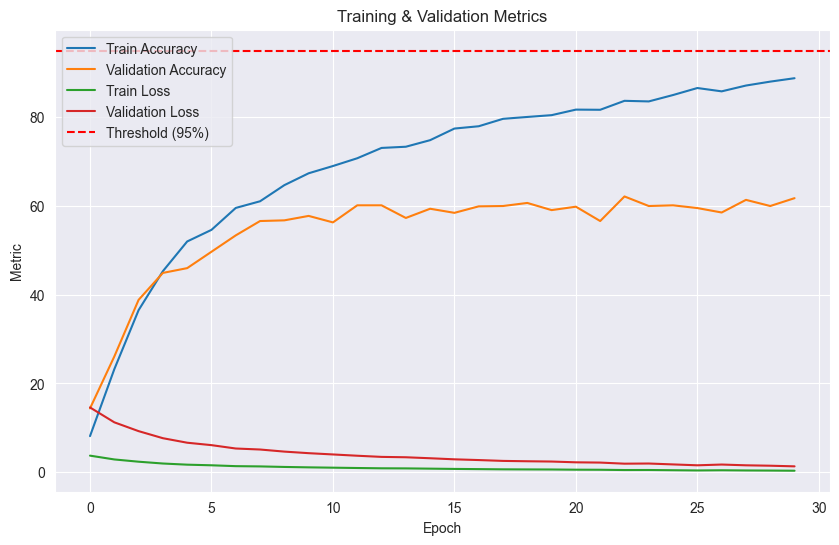

In [12]:
train_loss, val_loss, train_acc, val_acc = train(model_v2, optimizer=optimizer_v2, num_epochs=30)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

In [13]:
class CNN_v3(nn.Module):
    def __init__(self, num_classes=75):
        super(CNN_v3, self).__init__()
        #kernal_size=5 instead of kernal_size=3 
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten_size = self._get_flatten_size()
        
        self.fc1 = nn.Linear(in_features=self.flatten_size, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        
    def _get_flatten_size(self):
        x = torch.randn(1, 3, 150, 150)
        x = self.max_pool(F.relu(self.conv_layer1(x)))
        x = self.max_pool(F.relu(self.conv_layer2(x)))
        x = self.max_pool(F.relu(self.conv_layer3(x)))
        return x.view(1, -1).size(1)
        
    def forward(self, x):
        x = F.relu(self.conv_layer1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_layer2(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_layer3(x))
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        
        return x

In [14]:
model_v3 = CNN_v3(75).to(device)
optimizer_v3 = optim.Adam(model_v3.parameters(), lr=0.001)

100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Epoch (1/20) train accuracy: 6.8474706674360455, val accuracy: 14.0, train loss: 3.9266300056038834, val loss: 15.332555259977068


100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


Epoch (2/20) train accuracy: 22.773610309674936, val accuracy: 29.23076923076923, train loss: 2.915097143591904, val loss: 11.382760274977912


100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


Epoch (3/20) train accuracy: 35.41065589536449, val accuracy: 42.15384615384615, train loss: 2.3687482476234436, val loss: 9.249397919291543


100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


Epoch (4/20) train accuracy: 45.04712444700904, val accuracy: 46.15384615384615, train loss: 2.0064613092236403, val loss: 7.834753683635166


100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


Epoch (5/20) train accuracy: 50.06732063858434, val accuracy: 47.84615384615385, train loss: 1.817811957219752, val loss: 7.098122880572364


100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


Epoch (6/20) train accuracy: 53.221773417965, val accuracy: 52.84615384615385, train loss: 1.6617405836175128, val loss: 6.488701326506479


100%|██████████| 21/21 [00:17<00:00,  1.19it/s]


Epoch (7/20) train accuracy: 56.85708790151952, val accuracy: 52.38461538461539, train loss: 1.5213424330804406, val loss: 5.940479976790292


100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


Epoch (8/20) train accuracy: 59.29986535872283, val accuracy: 54.30769230769231, train loss: 1.39940959069787, val loss: 5.464361258915493


100%|██████████| 21/21 [00:18<00:00,  1.15it/s]


Epoch (9/20) train accuracy: 62.5312560107713, val accuracy: 51.07692307692308, train loss: 1.2785207491095474, val loss: 4.992319115570614


100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


Epoch (10/20) train accuracy: 64.7624543181381, val accuracy: 56.84615384615385, train loss: 1.1846354124022693, val loss: 4.62571922938029


100%|██████████| 21/21 [00:18<00:00,  1.16it/s]


Epoch (11/20) train accuracy: 67.12829390267359, val accuracy: 57.46153846153846, train loss: 1.1308427518460809, val loss: 4.415671697684696


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Epoch (12/20) train accuracy: 68.28236199269091, val accuracy: 55.76923076923077, train loss: 1.063597270628301, val loss: 4.153094104358128


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Epoch (13/20) train accuracy: 70.6866705135603, val accuracy: 57.69230769230769, train loss: 0.9742788040056461, val loss: 3.804326758498237


100%|██████████| 21/21 [00:18<00:00,  1.16it/s]


Epoch (14/20) train accuracy: 71.10982881323332, val accuracy: 59.30769230769231, train loss: 0.9494967380674874, val loss: 3.7075586915016174


100%|██████████| 21/21 [00:16<00:00,  1.24it/s]


Epoch (15/20) train accuracy: 72.70628967109059, val accuracy: 60.0, train loss: 0.8958151144225422, val loss: 3.49794473250707


100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Epoch (16/20) train accuracy: 74.89901904212348, val accuracy: 59.69230769230769, train loss: 0.8144295448210181, val loss: 3.1801534607296897


100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Epoch (17/20) train accuracy: 75.76457010963647, val accuracy: 59.92307692307692, train loss: 0.7825924183537321, val loss: 3.0558370621431443


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Epoch (18/20) train accuracy: 77.28409309482593, val accuracy: 62.0, train loss: 0.7472249556605409, val loss: 2.9177355411506833


100%|██████████| 21/21 [00:18<00:00,  1.17it/s]


Epoch (19/20) train accuracy: 77.9380650125024, val accuracy: 62.0, train loss: 0.6884827210408885, val loss: 2.688361101207279


100%|██████████| 21/21 [00:18<00:00,  1.16it/s]


Epoch (20/20) train accuracy: 79.7461050201962, val accuracy: 61.30769230769231, train loss: 0.6676917032497686, val loss: 2.6071771269752864


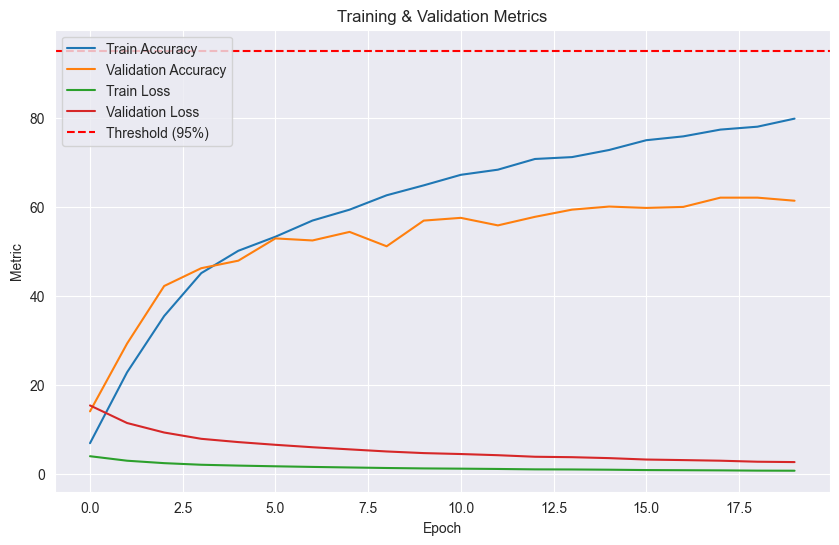

In [15]:
train_loss, val_loss, train_acc, val_acc = train(model_v3, optimizer=optimizer_v3, num_epochs=20)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

In [16]:
class CNN_v4(nn.Module):
    def __init__(self, num_classes=75):
        super(CNN_v4, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        #batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)

        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten_size = self._get_flatten_size()
        #add dropout
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(in_features=self.flatten_size, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        
    def _get_flatten_size(self):
        x = torch.randn(1, 3, 150, 150)
        x = self.max_pool(F.relu(self.conv_layer1(x)))
        x = self.max_pool(F.relu(self.conv_layer2(x)))
        x = self.max_pool(F.relu(self.conv_layer3(x)))
        return x.view(1, -1).size(1)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv_layer1(x)))
        x = self.max_pool(x)
        x = F.relu(self.bn2(self.conv_layer2(x)))
        x = self.max_pool(x)
        x = F.relu(self.bn3(self.conv_layer3(x)))
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x))) 
        x = self.fc2(x) 
        
        return x

In [17]:
model_v4 = CNN_v4(75).to(device)
optimizer_v4 = optim.Adam(model_v4.parameters(), lr=0.001)

100%|██████████| 21/21 [00:16<00:00,  1.28it/s]


Epoch (1/30) train accuracy: 1.250240430852087, val accuracy: 1.1538461538461537, train loss: 4.46214352002958, val loss: 17.42360803059169


100%|██████████| 21/21 [00:15<00:00,  1.35it/s]


Epoch (2/30) train accuracy: 3.058280438545874, val accuracy: 2.769230769230769, train loss: 4.251333451852566, val loss: 16.60044490723383


100%|██████████| 21/21 [00:15<00:00,  1.36it/s]


Epoch (3/30) train accuracy: 3.2890940565493363, val accuracy: 2.769230769230769, train loss: 4.125410739968463, val loss: 16.108746698924474


100%|██████████| 21/21 [00:15<00:00,  1.35it/s]


Epoch (4/30) train accuracy: 3.1544527793806503, val accuracy: 1.9230769230769231, train loss: 4.069744671263346, val loss: 15.891383954456874


100%|██████████| 21/21 [00:15<00:00,  1.36it/s]


Epoch (5/30) train accuracy: 2.7889978842085017, val accuracy: 2.230769230769231, train loss: 4.033144287946747, val loss: 15.748468171982537


100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


Epoch (6/30) train accuracy: 2.942873629544143, val accuracy: 2.8461538461538463, train loss: 4.0183217787161105, val loss: 15.690589802605766


100%|██████████| 21/21 [00:15<00:00,  1.36it/s]


Epoch (7/30) train accuracy: 3.1544527793806503, val accuracy: 2.4615384615384617, train loss: 4.0017633350884045, val loss: 15.62593302272615


100%|██████████| 21/21 [00:15<00:00,  1.36it/s]


Epoch (8/30) train accuracy: 3.231390652048471, val accuracy: 3.0, train loss: 3.9840761742940765, val loss: 15.55686887105306


100%|██████████| 21/21 [00:16<00:00,  1.28it/s]


Epoch (9/30) train accuracy: 3.250625120215426, val accuracy: 2.6923076923076925, train loss: 3.9579842439511927, val loss: 15.454986095428467


100%|██████████| 21/21 [00:15<00:00,  1.38it/s]


Epoch (10/30) train accuracy: 4.7893825735718405, val accuracy: 4.615384615384615, train loss: 3.904804337315443, val loss: 15.247331221898397


100%|██████████| 21/21 [00:15<00:00,  1.33it/s]


Epoch (11/30) train accuracy: 5.635699172917869, val accuracy: 4.538461538461538, train loss: 3.761578998914579, val loss: 14.688070376714071


100%|██████████| 21/21 [00:16<00:00,  1.28it/s]


Epoch (12/30) train accuracy: 6.212733217926524, val accuracy: 7.538461538461538, train loss: 3.617886293225172, val loss: 14.12698457354591


100%|██████████| 21/21 [00:15<00:00,  1.38it/s]


Epoch (13/30) train accuracy: 8.405462588959415, val accuracy: 9.461538461538462, train loss: 3.539260233320841, val loss: 13.81996853010995


100%|██████████| 21/21 [00:16<00:00,  1.30it/s]


Epoch (14/30) train accuracy: 8.847855356799384, val accuracy: 8.076923076923077, train loss: 3.480459370264193, val loss: 13.59036516007923


100%|██████████| 21/21 [00:15<00:00,  1.38it/s]


Epoch (15/30) train accuracy: 9.117137911136757, val accuracy: 10.23076923076923, train loss: 3.4415945599718794, val loss: 13.438607329414005


100%|██████████| 21/21 [00:15<00:00,  1.35it/s]


Epoch (16/30) train accuracy: 9.867282169648009, val accuracy: 11.23076923076923, train loss: 3.3858285706217695, val loss: 13.22085441861834


100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


Epoch (17/30) train accuracy: 11.040584727832275, val accuracy: 10.692307692307692, train loss: 3.360941098957527, val loss: 13.123674767357963


100%|██████████| 21/21 [00:15<00:00,  1.36it/s]


Epoch (18/30) train accuracy: 10.578957491825351, val accuracy: 11.384615384615385, train loss: 3.313159698393287, val loss: 12.937099774678549


100%|██████████| 21/21 [00:15<00:00,  1.33it/s]


Epoch (19/30) train accuracy: 11.348336218503558, val accuracy: 12.461538461538462, train loss: 3.2866556062930967, val loss: 12.833607605525426


100%|██████████| 21/21 [00:16<00:00,  1.28it/s]


Epoch (20/30) train accuracy: 11.598384304673976, val accuracy: 12.923076923076923, train loss: 3.2728508769012077, val loss: 12.779703424090432


100%|██████████| 21/21 [00:15<00:00,  1.37it/s]


Epoch (21/30) train accuracy: 11.713791113675708, val accuracy: 12.384615384615385, train loss: 3.2270115817465435, val loss: 12.60071189062936


100%|██████████| 21/21 [00:15<00:00,  1.31it/s]


Epoch (22/30) train accuracy: 12.252356222350452, val accuracy: 12.538461538461538, train loss: 3.1908904023286775, val loss: 12.459667285283407


100%|██████████| 21/21 [00:15<00:00,  1.36it/s]


Epoch (23/30) train accuracy: 13.848817080207732, val accuracy: 18.307692307692307, train loss: 3.094496790955706, val loss: 12.083273183731805


100%|██████████| 21/21 [00:15<00:00,  1.33it/s]


Epoch (24/30) train accuracy: 20.40777072513945, val accuracy: 20.76923076923077, train loss: 2.744894495824488, val loss: 10.718159459886097


100%|██████████| 21/21 [00:15<00:00,  1.39it/s]


Epoch (25/30) train accuracy: 24.6778226582035, val accuracy: 24.0, train loss: 2.5681769353587454, val loss: 10.028119461877006


100%|██████████| 21/21 [00:15<00:00,  1.33it/s]


Epoch (26/30) train accuracy: 29.371032890940565, val accuracy: 29.76923076923077, train loss: 2.3608034064130083, val loss: 9.218375205993652


100%|██████████| 21/21 [00:16<00:00,  1.31it/s]


Epoch (27/30) train accuracy: 32.71783035199077, val accuracy: 31.76923076923077, train loss: 2.2272399053341005, val loss: 8.696841535114107


100%|██████████| 21/21 [00:15<00:00,  1.37it/s]


Epoch (28/30) train accuracy: 35.58376610886709, val accuracy: 34.76923076923077, train loss: 2.1330343368576794, val loss: 8.32899122011094


100%|██████████| 21/21 [00:15<00:00,  1.33it/s]


Epoch (29/30) train accuracy: 39.8730525100981, val accuracy: 36.61538461538461, train loss: 2.0280980046202495, val loss: 7.919239827564785


100%|██████████| 21/21 [00:16<00:00,  1.29it/s]


Epoch (30/30) train accuracy: 40.77707251394499, val accuracy: 36.69230769230769, train loss: 1.9838580023951646, val loss: 7.74649315220969


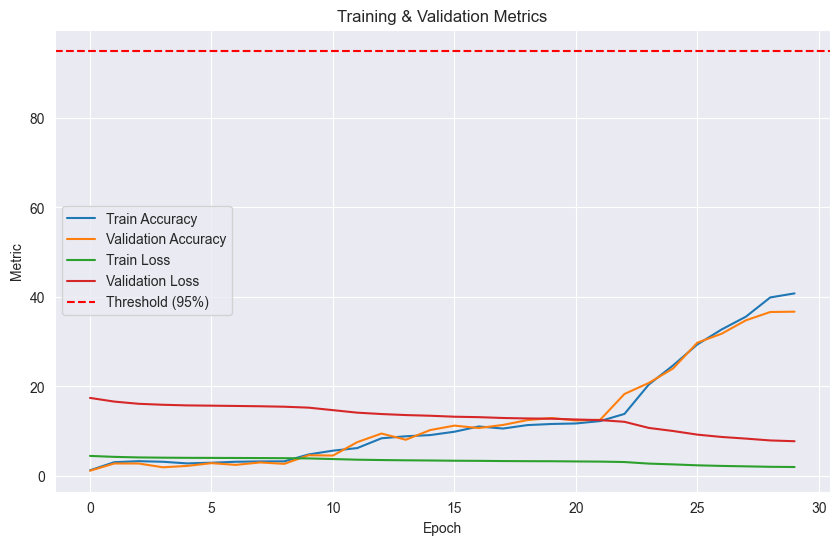

In [18]:
train_loss, val_loss, train_acc, val_acc = train(model_v4,optimizer=optimizer_v4,  num_epochs=30)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

In [43]:
class CNN_v5(nn.Module):
    def __init__(self, num_classes=75):
        super(CNN_v5, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten_size = self._get_flatten_size()
        #add dropout
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(in_features=self.flatten_size, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=num_classes)
        
    def _get_flatten_size(self):
        x = torch.randn(1, 3, 150, 150)
        x = self.max_pool(F.relu(self.bn1(self.conv_layer1(x))))
        x = self.max_pool(F.relu(self.bn2(self.conv_layer2(x))))
        x = self.max_pool(F.relu(self.bn3(self.conv_layer3(x))))
        return x.view(1, -1).size(1)
        
    def forward(self, x):
        x = F.relu(self.conv_layer1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_layer2(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_layer3(x))
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout1(F.relu(self.fc1(x))) 
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

In [44]:
model_v5 = CNN_v5(75).to(device)
optimizer_v5 = optim.Adam(model_v5.parameters(), lr=0.001)

100%|██████████| 21/21 [00:23<00:00,  1.14s/it]


Epoch (1/30) train accuracy: 3.8468936333910366, val accuracy: 8.076923076923077, train loss: 4.112113400203426, val loss: 16.05682375317528


100%|██████████| 21/21 [00:17<00:00,  1.20it/s]


Epoch (2/30) train accuracy: 13.367955376033853, val accuracy: 17.846153846153847, train loss: 3.2658761826957146, val loss: 12.752468903859457


100%|██████████| 21/21 [00:17<00:00,  1.19it/s]


Epoch (3/30) train accuracy: 23.869974995191384, val accuracy: 27.615384615384617, train loss: 2.8178476676708315, val loss: 11.003024226143246


100%|██████████| 21/21 [00:17<00:00,  1.17it/s]


Epoch (4/30) train accuracy: 32.21773417964993, val accuracy: 32.92307692307692, train loss: 2.4650787464002284, val loss: 9.625545581181845


100%|██████████| 21/21 [00:17<00:00,  1.20it/s]


Epoch (5/30) train accuracy: 38.69974995191383, val accuracy: 40.84615384615385, train loss: 2.188356488216214, val loss: 8.545011049225216


100%|██████████| 21/21 [00:17<00:00,  1.20it/s]


Epoch (6/30) train accuracy: 45.066358915176, val accuracy: 43.84615384615385, train loss: 1.9230196156152866, val loss: 7.508933737164452


100%|██████████| 21/21 [00:17<00:00,  1.20it/s]


Epoch (7/30) train accuracy: 49.56722446624351, val accuracy: 47.07692307692308, train loss: 1.7536727916903612, val loss: 6.847674710409982


100%|██████████| 21/21 [00:17<00:00,  1.20it/s]


Epoch (8/30) train accuracy: 53.2602423542989, val accuracy: 49.38461538461539, train loss: 1.5929237720442981, val loss: 6.219988062268212


100%|██████████| 21/21 [00:18<00:00,  1.14it/s]


Epoch (9/30) train accuracy: 55.89536449317176, val accuracy: 48.76923076923077, train loss: 1.4862706210555099, val loss: 5.803532901264372


100%|██████████| 21/21 [00:17<00:00,  1.18it/s]


Epoch (10/30) train accuracy: 58.799769186381994, val accuracy: 54.46153846153846, train loss: 1.376809108548048, val loss: 5.3761117571876165


100%|██████████| 21/21 [00:17<00:00,  1.18it/s]


Epoch (11/30) train accuracy: 61.24254664358531, val accuracy: 53.69230769230769, train loss: 1.2681550369030092, val loss: 4.951843477430797


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Epoch (12/30) train accuracy: 63.45451048278515, val accuracy: 51.61538461538461, train loss: 1.2097184432715904, val loss: 4.723662492774782


100%|██████████| 21/21 [00:18<00:00,  1.15it/s]


Epoch (13/30) train accuracy: 65.24331602231199, val accuracy: 52.61538461538461, train loss: 1.1271893236695267, val loss: 4.401405930519104


100%|██████████| 21/21 [00:23<00:00,  1.13s/it]


Epoch (14/30) train accuracy: 67.82073475668398, val accuracy: 54.53846153846154, train loss: 1.0389791603495435, val loss: 4.056966245174408


100%|██████████| 21/21 [00:22<00:00,  1.06s/it]


Epoch (15/30) train accuracy: 69.82111944604732, val accuracy: 54.76923076923077, train loss: 0.968931496870227, val loss: 3.783446797302791


100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


Epoch (16/30) train accuracy: 69.70571263704558, val accuracy: 57.61538461538461, train loss: 0.9556911929351527, val loss: 3.731746562889644


100%|██████████| 21/21 [00:33<00:00,  1.60s/it]


Epoch (17/30) train accuracy: 73.26408924793229, val accuracy: 58.23076923076923, train loss: 0.857127976853673, val loss: 3.3468806715238664


100%|██████████| 21/21 [00:23<00:00,  1.14s/it]


Epoch (18/30) train accuracy: 75.61069436430083, val accuracy: 54.92307692307692, train loss: 0.7848694171847367, val loss: 3.0647282004356384


100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


Epoch (19/30) train accuracy: 76.47624543181381, val accuracy: 57.92307692307692, train loss: 0.7382451357637964, val loss: 2.8826714825062525


100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


Epoch (20/30) train accuracy: 76.59165224081553, val accuracy: 57.61538461538461, train loss: 0.7189968264684444, val loss: 2.807511417638688


100%|██████████| 21/21 [00:16<00:00,  1.31it/s]


Epoch (21/30) train accuracy: 78.20734756683977, val accuracy: 59.23076923076923, train loss: 0.6562238749934406, val loss: 2.562397988069625


100%|██████████| 21/21 [00:14<00:00,  1.46it/s]


Epoch (22/30) train accuracy: 79.4383535295249, val accuracy: 58.30769230769231, train loss: 0.636894306395112, val loss: 2.4869206249713898


100%|██████████| 21/21 [00:17<00:00,  1.20it/s]


Epoch (23/30) train accuracy: 80.32313906520484, val accuracy: 57.38461538461539, train loss: 0.5980756282806396, val loss: 2.3353429294767833


100%|██████████| 21/21 [00:20<00:00,  1.01it/s]


Epoch (24/30) train accuracy: 81.95806885939604, val accuracy: 59.23076923076923, train loss: 0.5555229219721585, val loss: 2.1691847429389046


100%|██████████| 21/21 [00:23<00:00,  1.10s/it]


Epoch (25/30) train accuracy: 82.24658588190036, val accuracy: 59.76923076923077, train loss: 0.5318740013895965, val loss: 2.076841338759377


100%|██████████| 21/21 [00:20<00:00,  1.04it/s]


Epoch (26/30) train accuracy: 83.05443354491248, val accuracy: 58.84615384615385, train loss: 0.49361131231232386, val loss: 1.9274346480766933


100%|██████████| 21/21 [00:20<00:00,  1.05it/s]


Epoch (27/30) train accuracy: 82.99673014041161, val accuracy: 58.69230769230769, train loss: 0.49641383493818886, val loss: 1.9383778316634042


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch (28/30) train accuracy: 85.26639738411232, val accuracy: 58.61538461538461, train loss: 0.4391512518248907, val loss: 1.7147810785543351


100%|██████████| 21/21 [00:18<00:00,  1.16it/s]


Epoch (29/30) train accuracy: 85.99730717445662, val accuracy: 60.46153846153846, train loss: 0.42901607966277655, val loss: 1.6752056443975085


100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


Epoch (30/30) train accuracy: 87.3437199461435, val accuracy: 60.15384615384615, train loss: 0.38268326549995235, val loss: 1.4942870367140997


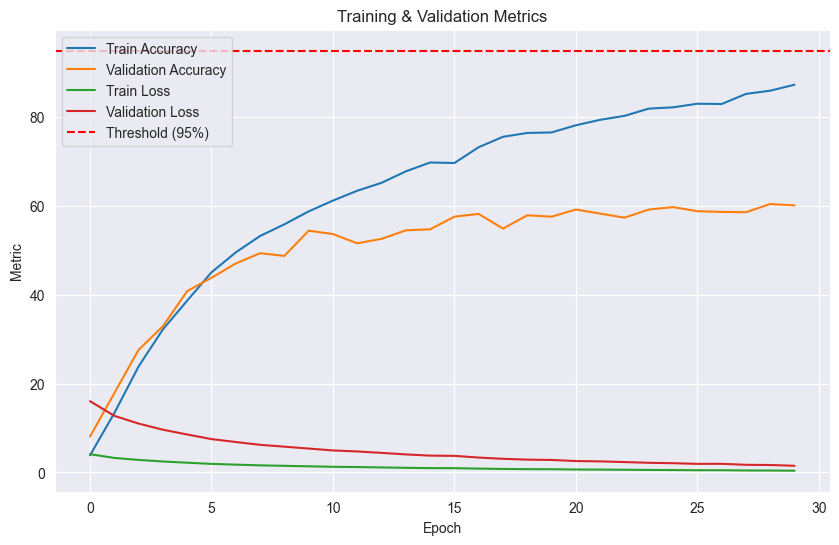

In [45]:
train_loss, val_loss, train_acc, val_acc = train(model_v5,optimizer=optimizer_v5,  num_epochs=30)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)